In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
# ライブラリ・データセットのインポート
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

## 実行時間を調べるために使う
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

FILE_PATH = '/kaggle/input/playground-series-s3e26/'
OUTPUT_DIR = '/kaggle/working/'

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

test_id = test['id']

target = train['Status']

target_name = str(train.iloc[:, [18]].columns.tolist()) # カラム数-2の値が目的変数

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns
numerical_features = numerical_features.drop('id')

# 前処理
# 欠損値の補完
def missing_values(df):

    return df

# 外れ値の削除
def outlier(df):

    return df

# MinMaxScaler(正規化)
def scaling(df):
    df_scale = df[numerical_features]
    sc = MinMaxScaler()
    df[numerical_features] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

# 特徴量エンジニアリング
# 特徴量の作成
def create_new_features(df):
    # 血小板減少症インジケーター
    threshold_platelets = 150 # 閾値
    df['thrombocytopenia'] = np.where(df['Platelets'] < threshold_platelets, 1, 0)

    # アルカリ性リン酸塩ホスファターゼの上昇指標：
    threshold_alk_phos_upper = 147
    threshold_alk_phos_lower = 44
    df['elevated_alk_phos'] = np.where((df['Alk_Phos'] > threshold_alk_phos_upper) | (df['Alk_Phos'] < threshold_alk_phos_lower), 1, 0)

    # 正常な銅レベル
    normal_copper_range = (62, 140)
    df['normal_copper'] = np.where((df['Copper'] >= normal_copper_range[0]) & (df['Copper'] <= normal_copper_range[1]), 1, 0)

    # アルブミンの正常範囲
    normal_albumin_range = (3.4, 5.4)
    df['normal_albumin'] = np.where((df['Albumin'] >= normal_albumin_range[1]), 1, 0)

    # 正常なビリルビンレベル
    normal_bilirubin_range = (0.2, 1.2)
    df['normal_bilirubin'] = np.where((df['Bilirubin'] >= normal_bilirubin_range[0]) & (df['Bilirubin'] <= normal_bilirubin_range[1]), 1, 0)

    # 診断日
    df['DiagnosisDays'] = df['Age'] - df['N_Days']

    # ビリルビン * アルブミン
    df['Bilirubin_Albumin'] = df['Bilirubin'] * df['Albumin']

    # 症状のスコア
    symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders']
    df['Symptom_Score'] = df[symptom_columns].sum(axis=1)

    # 肝臓機能
    liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
    df['Liver_Function_Index'] = df[liver_columns].mean(axis=1)

    # リスクスコア
    df['Risk_Score'] = df['Bilirubin'] + df['Albumin'] - df['Alk_Phos']

    # 時間特徴量
    df['Diag_Year'] = (df['N_Days'] / 365).astype(int)
    df['Diag_Month'] = ((df['N_Days'] % 365) / 30).astype(int)

    return df

# 年齢に関する特徴量の追加
def convert_days_to_years(age_in_days):
    days_in_year = 365.25
    age_in_years = age_in_days / days_in_year

    return age_in_years

def add_cols(df):
    age = list(df.Age)
    age_in_year = []
    for i in age:
        age_in_year.append(int(convert_days_to_years(i)))
    df['Age_in_year'] = pd.Series(age_in_year)

    return df

# カテゴリ変数のエンコーディング
# One-Hot Encoding
def one_hot_encoding(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)
    # 目的変数を数値化(int64)する
    df['Status'] = df['Status'].map({"C": 0, "CL": 1, "D": 2})
    # 一緒にラベルエンコーディングすると、1,2,3になってしまいモデル学習できないため分割する

    return df

# LabelEncoding
def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])

    return df

# 特徴量の選択
# 特徴量の重要度評価
def feature_importance_evaluation(df):
    # データを対数変換する

    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop(['Status'], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    for column in X.columns.tolist():
        X[column] = X[column].apply(lambda x: np.log(x + 1))

    # 特徴量の重要度評価
    lgb = LGBMClassifier(
        random_state=42,
    )

    lgb.fit(X, y)
    importance = lgb.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

# 特徴量の削除
def drop_columns(df):
    drop_list = [
#         'index'
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

# データセットの更新
# 前処理
df = add_cols(df)
df = missing_values(df)
df = outlier(df)
# df = scaling(df) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = drop_columns(df)

cat_cols = ['Edema', 'Stage'] # One-Hot Encodingしたい水準数の少ないカラムを指定する
df = one_hot_encoding(df, cat_cols)
df = label_encoder(df)

train = df[df.loc[:, 'id'] < 7905]
test = df[df.loc[:, 'id'] >= 7905]

train_x = train.drop(columns=['Status', 'id'])
train_y = target
test_x = test.drop(columns=['Status', 'id'])

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.head()

# ID削除
# df.drop("id", axis=1, inplace=True)

df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

# 確認 (data_import.py)
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:7905].reset_index(drop=True)
    test = data[7905:].reset_index(drop=True).drop('Status', axis=1)
    # 目的変数と説明変数に分割
    X = train.drop('Status', axis=1)
    y = train['Status'].values
    return data,test,train,X,y

filename = OUTPUT_DIR + 'data.csv'
data,test,train,X,y = file_to_xy(filename)

読み込み完了 /kaggle/working/data.csv


In [3]:
train = train.copy()
X = X.copy()
Y = y.copy()
lbe_test = test.copy()

In [4]:
# バリデーション
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, train_test_split

# ハイパーパラメータ
import optuna

# 機械学習モデル
from xgboost import XGBClassifier


In [5]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score, confusion_matrix, log_loss

import optuna
from lightgbm import LGBMRegressor, LGBMClassifier, log_evaluation, early_stopping
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state = 2610, stratify = y)
skf = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2610)

In [7]:
models = [GradientBoostingClassifier(), 
         HistGradientBoostingClassifier(), 
         LGBMClassifier(objective = 'multi_logloss'),
         XGBClassifier(eval_metric = 'mlogloss'),
         CatBoostClassifier(loss_function = 'MultiClass',
                                           iterations = 500,
                                           learning_rate = 0.01,
                                           verbose = False,
                                           task_type = 'GPU')
         ]
scores = []
for model in models:
  cv = cross_val_score(model,
                       X_train, 
                       y_train, 
                       scoring = 'neg_log_loss',
                       cv = skf, 
                       n_jobs = 1)
  scores.append(cv.mean())


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

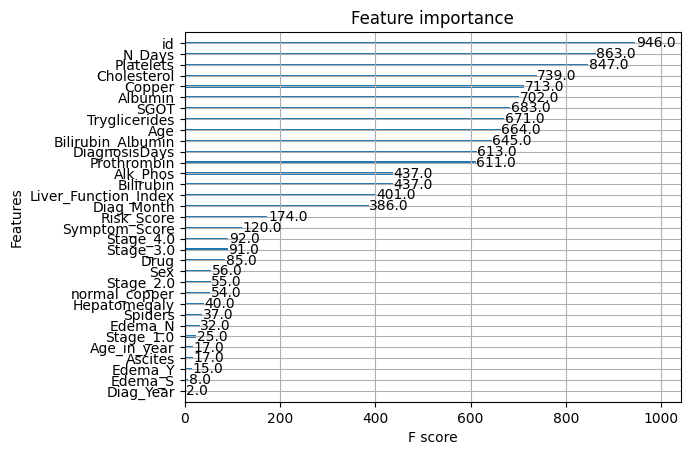

In [8]:
import xgboost
xgb = XGBClassifier(eval_metric = 'mlogloss')
xgb.fit(X_train, y_train)
xgboost.plot_importance(xgb)

In [9]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
feat_importance = {a: b for a, b in zip(X_train.columns.values, gb.feature_importances_)}
feat_importance_rd = dict(sorted(feat_importance.items(), key = lambda x : x[1], reverse = True))
pd_feat_importance = pd.Series(feat_importance_rd.values(), feat_importance_rd.keys())
pd_feat_importance

Bilirubin               0.434885
N_Days                  0.148292
Prothrombin             0.081672
Copper                  0.054947
Symptom_Score           0.043657
Stage_4.0               0.031876
Age                     0.027306
SGOT                    0.023443
DiagnosisDays           0.020311
Cholesterol             0.019317
Platelets               0.019088
Tryglicerides           0.015299
Liver_Function_Index    0.014675
Risk_Score              0.012769
Albumin                 0.011031
Bilirubin_Albumin       0.007707
id                      0.005820
Age_in_year             0.005574
Edema_N                 0.004977
Edema_Y                 0.004706
Sex                     0.003512
Drug                    0.001686
Stage_1.0               0.001664
Diag_Month              0.001345
Hepatomegaly            0.001126
Alk_Phos                0.001122
normal_copper           0.000901
Diag_Year               0.000828
Spiders                 0.000410
normal_bilirubin        0.000026
Stage_2.0 

In [10]:
def objective_lgb(trial):
    """Define the objective function"""
    params = {
        'objective': trial.suggest_categorical('objective', ['multi_logloss']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }

    params = {
        'objective': trial.suggest_categorical('objective', ['multi_logloss']),
        'max_depth': trial.suggest_int('max_depth', 7, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 13, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.013, 0.04),
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 7, 10),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.05, 0.2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.05, 1.0),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }


    lgb = LGBMClassifier(**params, device = 'gpu', n_jobs = -1)
    cv = abs(cross_val_score(lgb, X_train, y_train, cv = skf,scoring='neg_log_loss').mean())
    return cv

In [11]:
# %%time
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_lgb, n_trials=100, timeout=2000)

In [12]:
# [I 2023-12-22 04:24:17,624] Trial 88 finished with value: 0.4414199165690038 and 
lgbm_params = {'objective': 'multi_logloss', 
             'max_depth': 7, 'min_child_samples': 11, 
             'learning_rate': 0.01566483845941954, 
             'n_estimators': 966, 'min_child_weight': 9, 
             'subsample': 0.45579910488195635, 
             'colsample_bytree': 0.0757022595046426, 
             'reg_alpha': 0.9766398799933541, 
             'reg_lambda': 0.48128958254209964, 
             'random_state': 42}
#         . Best is trial 88 with value: 0.4414199165690038.

lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model.fit(X, y)

LGBMClassifier(colsample_bytree=0.0757022595046426,
               learning_rate=0.01566483845941954, max_depth=7,
               min_child_samples=11, min_child_weight=9, n_estimators=966,
               objective='multi_logloss', random_state=42,
               reg_alpha=0.9766398799933541, reg_lambda=0.48128958254209964,
               subsample=0.45579910488195635)

In [13]:
# lgbm_params = {'objective': 'multi_logloss', 
#                'max_depth': 9, 'min_child_samples': 14, 
#                'learning_rate': 0.034869481921747415, 
#                'n_estimators': 274, 'min_child_weight': 9, 
#                'subsample': 0.7717873512945741, 
#                'colsample_bytree': 0.1702910221565107, 
#                'reg_alpha': 0.10626128775335533, 
#                'reg_lambda': 0.624196407787772, 
#                'random_state': 42}
# lgbm_model = LGBMClassifier(**lgbm_params)
# lgbm_model.fit(X, y)

In [14]:
log_loss(y_test, lgbm_model.predict_proba(X_test))

0.2723159926186088

In [15]:
preds = lgbm_model.predict_proba(lbe_test)
preds = pd.DataFrame(preds, columns = ['D', 'C', 'CL'])
sub = pd.DataFrame(test_id)
sub['Status_C'] = preds['C']
sub['Status_CL'] = preds['CL']
sub['Status_D'] = preds['D']


In [16]:
sub.to_csv('submission.csv', index = False)
sub

,id,Status_C,Status_CL,Status_D
0,7905,0.026254,0.568772,0.404974
1,7906,0.315279,0.154546,0.530175
2,7907,0.011667,0.955533,0.032800
3,7908,0.001809,0.035563,0.962628
4,7909,0.074500,0.080086,0.845414
...,...,...,...,...
5266,13171,0.062986,0.049190,0.887824
5267,13172,0.005225,0.033653,0.961122
5268,13173,0.012519,0.049859,0.937622
5269,13174,0.004498,0.009753,0.985749
